# 07 Väärinfo mudelid

Inspiratsioon ja algallikad:
1. Fake news detector
https://www.kaggle.com/rodolfoluna/fake-news-detector
2. Fake and real news dataset
https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
3. https://github.com/DARIAH-DE/tatom/tree/develop/source
4. Classification of text documents using sparse features
https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html
5. KNN Classification using Scikit-learn
https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034349&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9061567&gclid=CjwKCAiA-_L9BRBQEiwA-bm5fmXHZ5wjftR4hIRqhltZGr54molVq8Rf41i21I7aOOhgxu9MTO2FhBoCfSQQAvD_BwE
6. Text classification using K Nearest Neighbors (KNN)
https://iq.opengenus.org/text-classification-using-k-nearest-neighbors/
7. Text Classification with Python and Scikit-Learn
https://stackabuse.com/text-classification-with-python-and-scikit-learn/
8. Advanced Python Project – Detecting Fake News with Python (PassiveAggressiveClassifier)
https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/
9. How to Use Tfidftransformer & Tfidfvectorizer?
https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X9EGg2gzZPZ
10. Latent Dirichlet Allocation
https://radimrehurek.com/gensim/models/ldamodel.html
11. How Naive Bayes Algorithm Works? (with example and full code)
https://www.machinelearningplus.com/predictive-modeling/how-naive-bayes-algorithm-works-with-example-and-full-code/#9buildingnaivebayesclassifierinpython

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from estnltk import Text
from tqdm import tqdm
import re
from estnltk.wordnet import Wordnet
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
fake = pd.read_csv("fake.csv")
true = pd.read_csv("true.csv")
print("Valeuudiseid: ", fake.shape)
print("Tõeseid uudiseid: ", true.shape)

Valeuudiseid:  (100, 5)
Tõeseid uudiseid:  (100, 5)


In [88]:
#Väärinfo ja tõese info eristamine
fake['target'] = 'fake'
true['target'] = 'true'
# andmestike ühendamine
data = pd.concat([fake, true]).reset_index(drop = True)
print("Uudiseid: ", data.shape)

Uudiseid:  (200, 6)


In [89]:
# Andmestiku segamine
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [90]:
# Ebavajaliku info eemaldamine
data.drop(["date"],axis=1,inplace=True)
data.drop(["title"],axis=1,inplace=True)

In [91]:
data['text'] = data['text'].astype(str)

In [92]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka','nii','kas','kus', 'mis',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju', 'setu']
# stoppsõnade eemaldamine, stoppsõnadega peab TEGELEMA, kas eemaldada stoppsõnad siin või hiljem vektoriseerijas?
#data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopsõnad_uus)]))

# Segadusmaatriks (confusion matrix)

                  Väär  | tõeselt negatiivne | valepositiivne
                  _______________________________________________          Tegelik märgend
                  
                  Tõene | valenegatiivne     | tõeselt positiivne
                  _______________________________________________
                              Väär                Tõene
                  
                                Ennustatud märgend
   
                    

In [93]:
# Segadusmaatriks (plot the confusion matrix)
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Segadusmaatriks',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normaliseeritud segadusmaatriks")
    else:
        print('Normaliseerimata segadusmaatriks')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label/Tõeline märgend')
    plt.xlabel('Predicted label/Prognoositud märgend')

# Andmete tükeldamine mudelite treenimiseks

In [94]:
data.shape

(200, 4)

train_test_split - split arrays or matrices into random train and test subsets test_size - If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. If train_size is also None, it will be set to 0.25.

In [95]:
# Andmete tükeldamine treenimisandmestikuks ja testandmestikuks
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.3, random_state=42)

# Sõnade vektoresitused ja dokument-sõna maatriks

Matemaatilistele meetoditele meeldivad struktureeritud arvandmed: vektorid (lihtsustatult öeldes: arvude järjendid) ja maatriksid (lihtsustatult öeldes: arvude tabelid). Seetõttu tuleb enne statistiliste / masinõppe meetodite kasutuselevõtmist leida viis, kuidas "teisendada" oma tekstilised andmed arvandmeteks.

Tekstide automaatsel klassifitseerimisel või klasterdamisel viiakse analüüsitava korpuse dokumendid vektorkujule ehk:

luuakse iga korpuse sõna kohta vektor (arvude "järjend"), mille iga positsioon kirjeldab sõna esinemist ühes korpuse dokumendis;
kõigi sõnade vektoritest pannakse kokku maatriks (arvude "tabel"), mille järgi saab leida nii üksiksõnade esinemismustreid kui ka dokumenti iseloomustava sõnavaramustri.
Sarnasuste leidmisel tuginevadki statistilised meetodid maatriksile ning tekstide omadused, mis maatriksis ei kajastu (nt sõnade omavaheline järjekord, lausestus, süntaks vms) tulemust otseselt ka ei mõjuta. 

Klass CountVectorizer võimaldab luua sõnavektoreid, mille iga positsioon kirjeldab sõna esinemissagedust ühes dokumendis. Klassi initsialiseerimisel on võimalik täpsustada mitmeid teksti eeltöötluse samme, nt kas sõnad tuleks teisendada väiketähelisteks (vaikimisi: jah), kuidas (millise meetodi abil) jagada tekst sõnadeks ning millised sõnad on nn stopp-sõnad, mis tuleks välja jätta.

TfidfVectorizer kasutab sõnasageduste asemel TF-IDF-skoori, mis näitab, kuivõrd iseloomulik on sõna mingile tekstile korpuses. TF (term frequency) on sõna esinemissagedus tekstis, IDF (inverse document frequency) kajastab seda, kui paljudes korpuse dokumentides see sõna üldse esineb, TF-IDF on nende korrutis.

(Eesti keele töötlus Pythonis materjal)

## Eesti keele sõnestusvahendid

Teksti sõnestamine kasutades eesti keele sõnestusvahendeid. Seega loome meetodi, mis saab sisendiks sõne, sõnestab selle EstNLTK abil ning tagastab sõnade järjendi. Ning CountVectorizer-i loomisel täpsustame, et sõnestamiseks tuleks kasutada just seda meetodit. 
(Eesti keele töötlus Pythonis materjal)

In [96]:
from estnltk import Text

# Meetodid teksti sõnestamiseks estnltk abil
def tokenize_with_estnltk( input_string ):
    return Text(input_string).tag_layer(['words']).words.text

def lemmatize_with_estnltk(input_string):
    lemma = Text(input_string).tag_layer(['morph_analysis']).lemma
    # https://stackoverflow.com/questions/11264684/flatten-list-of-lists/11264799
    flattened  = [val for sublist in lemma for val in sublist]
    return flattened

# Mudelid

### Logistiline regressioon (Logistic regression)

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-'] not in stop_words.
  sorted(inconsistent))


Logistilise regressiooni mudeli ennustustäpsus: 80.0%
Normaliseerimata segadusmaatriks


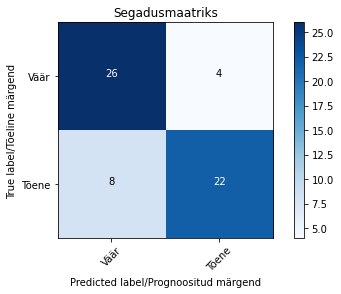

In [100]:
# Vektoriseerimine ja TF-IDF rakendamine
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer(tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Mudeli sobitamine
model = pipe.fit(X_train, y_train)

# Prognoosimine
prediction = model.predict(X_test)
print("Logistilise regressiooni mudeli ennustustäpsus: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
täpsus_logreg = round(accuracy_score(y_test, prediction)*100,2)
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Väär', 'Tõene'])

### Otsustuspuu (Decision Tree)

Otsustuspuu (nimetatakse ka klassifitseerimise ja regressiooni puu) on traditsiooniline osa andmekaevest ja masinõppe algoritmidest. Otsustuspuu atraktiivsus peitud mudeli lihtsuses ja arusaadavuses, mis võimaldab mudelit üle vaadata ja tõlgendada. Otsustuspuu ei ole alati parima täpsusega, kuid esindab kompromissi täpsuse ja mudeli arusaadavuse osas.

Otsustuspuu kasutab traditsioonilist struktuuri, kus aluseks on üks sõlm, mis jaguneb erinevateks harudeks (oksteks), mis omakorda tipnevad sõlmedega, millest igaüks võib edasi hargneda või lõppeda lehega. Iga sõlme juures on test või küsimus, mis määrab, millist haru mööda edasi minna kuni jõutakse leheni ehk otsuseni.https://masinope.ee/masinoppimine/

Otsustuspuu mudeli ennustustäpsus: 70.0%
Normaliseerimata segadusmaatriks


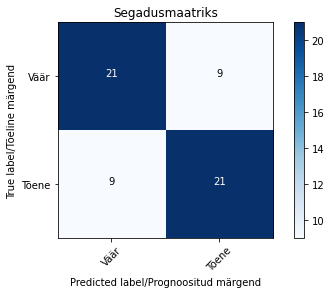

In [115]:
from sklearn.tree import DecisionTreeClassifier

# Vektoriseerimine ja TF-IDF rakendamine
pipe = Pipeline([('vect', CountVectorizer()),#tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Mudeli sobitamine
model = pipe.fit(X_train, y_train)

# Prognoosimine
prediction = model.predict(X_test)
print("Otsustuspuu mudeli ennustustäpsus: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
täpsus_DecTrCl = round(accuracy_score(y_test, prediction)*100,2)
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Väär', 'Tõene'])

### Juhuslik mets (Random Forest)


Ühe otsustuspuu loomine pakub lihtsat mudelit vaadeldava probleemi lahendamiseks, kuid tihtipeale jääb see liiga lihtsaks või spetsiifiliseks. Varasemad andmekaeve kogemused on näidanud, et mitmete mudelite koostöö annab paremaid tulemusi. Mitme mudeli (nt otsustuspuu) kombineerimine ühte mudelite kogumisse annab otsustuspuude metsa.

Juhusliku metsa puhul kasutatakse juhuslikku valikut nii vaatluste kui parameetrite valikul. Selle tulemusena on võimalik saavutada suurem sõltumatus andmete muutumisest, andmetes sisalduvast mürast ja ekstreemsetest vaatlustest ning ülemäärasest sobitamisest algandmetele. Samuti on juhusliku metsa eeliseks parem toimetulek tasakaalustamata treeningandmetega. Näiteks kui binaarse klassifikatsiooni korral on petturlikke tehinguid algbaasis vaid kuni 5% ja ülejäänud on legitiimsed tehingud.

Juhusliku metsa kasuks räägib ka asjaolu, et see ei nõua suurt andmete eeltöötlemist, sest andmeid ei pea normaliseerima. Samuti pole vaja tegeleda parameetrite valikuga, sest algoritm teeb seda ise. Kuna mudeli paljud puud on koostatud kahe taseme juhuslikkuse alusel (vaatlused ja parameetrid), siis on iga puu eraldi sõltumatu mudel ja koondmudel on kokkuvõttes treeningandmetest vähem sõltuv.
https://masinope.ee/masinoppimine/

Juhusliku metsa mudeli täpsus: 75.0%
Normaliseerimata segadusmaatriks


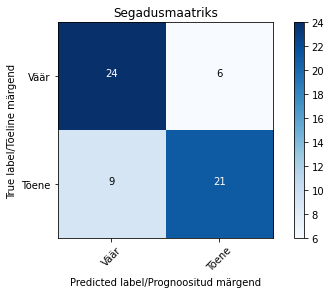

In [110]:
from sklearn.ensemble import RandomForestClassifier

# Vektoriseerimine ja TF-IDF rakendamine
pipe = Pipeline([('vect', CountVectorizer()),#tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
# Mudeli sobitamine
model = pipe.fit(X_train, y_train)

# Prognoosimine
prediction = model.predict(X_test)
print("Juhusliku metsa mudeli täpsus: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Väär', 'Tõene'])

## PassiveAgressiveClassifier

Agressiivse passiivse mudeli täpsus: 85.0%
Normaliseerimata segadusmaatriks


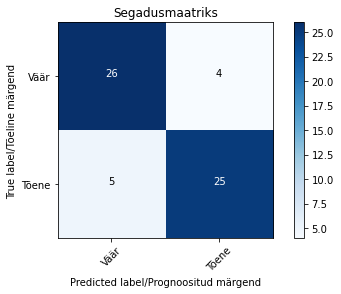

In [121]:
from sklearn.linear_model import PassiveAggressiveClassifier

# TF-IDF vektoriseerija rakendamine
tfidf_vectorizer=TfidfVectorizer() #tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)

# fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(X_train)
tfidf_test=tfidf_vectorizer.transform(X_test)

# Passiivse agressiivse klassifitseerija rakendamine
pac=PassiveAggressiveClassifier(max_iter=50)

# Mudeli sobitamine
pac.fit(tfidf_train,y_train)

# Prognoosimine
prediction=pac.predict(tfidf_test)
score=accuracy_score(y_test,prediction)
print(f'Agressiivse passiivse mudeli täpsus: {round(score*100,2)}%')
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Väär', 'Tõene'])

In [172]:
txt1 = ['Maa on lame!']
pac.predict(tfidf_vectorizer.transform(txt1))[0]

'fake'

In [173]:
txt2 = ['Praegu on talv. Varsti on Jõulud.']
pac.predict(tfidf_vectorizer.transform(txt2))[0]

'true'

In [174]:
txt3 = ['Maailma valitsevad ja juhivad kaugest galaktikast pärit roomajad. Nendel roomajatel on arvatavalt võime võtta inimkuju. Nad on Maa sisemuses asuvate jumalate rass ja nad on tulnud valguse kätte selleks, et Maad valitseda. Neid roomajaid on väga vähe, seepärast võtavadki nad meie planeedi oma kontrolli alla aeglaselt ja salaja.']
pac.predict(tfidf_vectorizer.transform(txt3))[0]

'fake'

In [175]:
txt4 = ['Globaalne soojenemine on jama. Selle teooria pooldajad väidavad, et teadlastel ei ole tõendeid selle kohta, et inimesed on põhjapooluse sulamise ja globaalse soojenemise peamine põhjus. Arvatakse, et teadlased on selle väite välja mõtelnud, et saada rohkem raha, mida siis oma vajadusteks kulutada, lastes paista, et nad otsivad lahendust atmosfääri soojenemise takistamiseks.']
pac.predict(tfidf_vectorizer.transform(txt4))[0]

'fake'

In [176]:
txt5 = ['Arktika on meie planeedi kõige kiiremini soojenev ala. Põhja-Jäämere triivjää sulab kiiresti. Tänapäeval ei saa me enam öelda, et Arktika soojeneb umbes kaks korda kiiremini kui terve maailm. See soojeneb juba maailmast kolm korda ja kohati veelgi kiiremini. 2020. aasta ei ole erand.']
pac.predict(tfidf_vectorizer.transform(txt5))[0]

'true'

In [177]:
txt6 = ['Tartu asub Emajõe kaldal.']
pac.predict(tfidf_vectorizer.transform(txt6))[0]

'true'

In [180]:
txt7 = ['Mina olen tegelikult teiselt planeedilt.']
pac.predict(tfidf_vectorizer.transform(txt7))[0]

'true'

Siinkohal ma lõpetan:)